In [163]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA

try:
    import seaborn as sns
except ImportError:
    %pip install seaborn
    import seaborn as sns

try:
    from word2number import w2n
except ImportError:
    %pip install word2number
    from word2number import w2n

import matplotlib.pyplot as plt
from scipy import stats

In [164]:
dataset = pd.read_csv('customer_dataset.csv')
dataset.head()

C:\Users\msi\AppData\Local\Temp\ipykernel_6056\2719005575.py:1: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv('customer_dataset.csv')


,customer_id,average_monthly_spend,average_monthly_visit_frequency,average_monthly_basket_size
0,1,790,1.11,2.84
1,2,176875,15.74,33.83
2,3,6812,2.11,NaN
3,4,38542,7.82,10.73
4,5,48712,7.51,10.04


In [165]:
#print all non numeric columns
for i in dataset.columns:
    if dataset[i].dtype == 'object':
        print(i)

average_monthly_spend
average_monthly_visit_frequency


In [166]:
#handling non-numeric data converting them to numeric
def word_to_num(value):
    try:
        return w2n.word_to_num(value)
    except ValueError:
        if value.isdigit():
            return int(value)
        elif value.replace('.', '', 1).isdigit() and value.count('.') < 2:
            return float(value)
        return None
    
for column in dataset.columns:
    dataset[column] = dataset[column].apply(lambda x : word_to_num(str(x)))

customer_id                           0
average_monthly_spend              9389
average_monthly_visit_frequency    9337
average_monthly_basket_size        9287
dtype: int64
Length of dataset: 570000
Rows with nan values: 28013
Ratio of rows with nan values: 5.0%


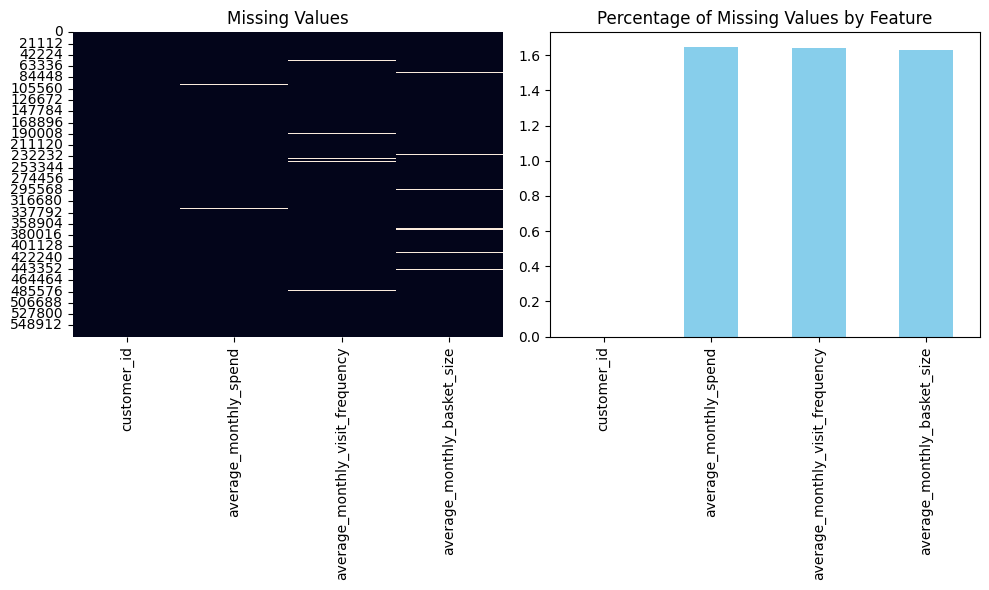

In [167]:
#nan count
print(dataset.isna().sum())
#length of dataset
print(f"Length of dataset: {len(dataset)}")
#count all the rows with nan values
rows_with_nan = dataset.isna().any(axis=1).sum()
print(f"Rows with nan values: {rows_with_nan}")
#ratio of rows with nan values
missing_percentage = dataset.isnull().mean() * 100
print(f"Ratio of rows with nan values: {round(rows_with_nan/len(dataset),2)*100}%")

plt.figure(figsize=(5,5))
plt.subplot(1, 2, 1)
plt.title('Missing Values')
sns.heatmap(dataset.isnull(), cbar=False)

plt.subplot(1, 2, 2)
missing_percentage.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Percentage of Missing Values by Feature')
plt.tight_layout()
plt.show()

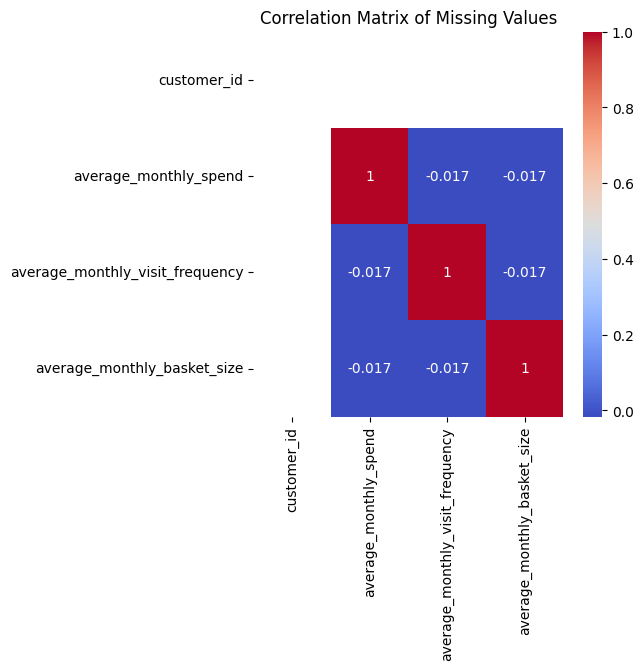

In [168]:
#correlation matrix to see the missing values are correlated
plt.figure(figsize=(5, 5))
corr_matrix = dataset.isnull().corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Missing Values')
plt.show()

In [169]:
#extract nan rows from dataset
nan_rows = dataset[dataset.isnull().any(axis=1)]
#replace nan with 0
dataset.dropna(inplace=True)
# Handle duplicates
dataset.drop_duplicates(inplace=True)

#replace nan with 0
nan_rows.fillna(0, inplace=True)
nan_rows

C:\Users\msi\AppData\Local\Temp\ipykernel_6056\1165969059.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nan_rows.fillna(0, inplace=True)


,customer_id,average_monthly_spend,average_monthly_visit_frequency,average_monthly_basket_size
2,3,6812.0,2.11,0.00
7,8,12656.0,2.13,0.00
24,25,41329.0,0.00,10.32
52,53,171010.0,0.00,35.03
53,54,104457.0,18.88,0.00
...,...,...,...,...
559914,559915,45023.0,0.00,9.82
559945,559946,49533.0,5.87,0.00
559959,559960,0.0,5.80,9.87
559970,559971,95444.0,19.85,0.00


In [170]:
iso_forest = IsolationForest(contamination=0.05, random_state=42)
features = ['average_monthly_spend','average_monthly_visit_frequency','average_monthly_basket_size']
data = dataset.copy()
# Fit the model
iso_forest.fit(data[features])

# Predict outliers
outliers = iso_forest.predict(data[features])

# Add the outlier predictions to the original data
data['outlier'] = outliers

# Display the rows identified as outliers
outliers_data = data[data['outlier'] == -1]

sns.pairplot(data, hue='outlier', palette={1: 'blue', -1: 'red'}, markers=["o", "s"])
plt.suptitle('Isolation Forest Outlier Detection', y=1.02)
plt.show()

In [171]:
data = dataset.copy()
Q1 = dataset.quantile(0.25)
Q3 = dataset.quantile(0.75)
IQR = Q3 - Q1

# Consider a data point an outlier if it is below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR
outliers = ((dataset < (Q1 - 1.5 * IQR)) | (dataset > (Q3 + 1.5 * IQR))).any(axis=1)
dataset = dataset[~outliers]

copy_dataset = dataset.copy()
data.describe()

,customer_id,average_monthly_spend,average_monthly_visit_frequency,average_monthly_basket_size
count,531990.000000,5.319900e+05,531990.000000,531990.000000
mean,280059.070229,4.825899e+04,6.879288,13.292845
std,161689.312262,9.173203e+04,5.323171,12.039045
min,1.000000,0.000000e+00,0.000000,0.000000
25%,139927.250000,1.049900e+04,2.390000,3.800000
50%,280109.500000,3.195900e+04,5.600000,9.790000
75%,420171.750000,8.541800e+04,9.850000,17.480000
max,560000.000000,4.833000e+07,432.740000,385.040000


In [172]:
#scale
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset.iloc[:, 1:])
scaled_data_nan = scaler.transform(nan_rows.iloc[:, 1:])

In [173]:
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(scaled_data)


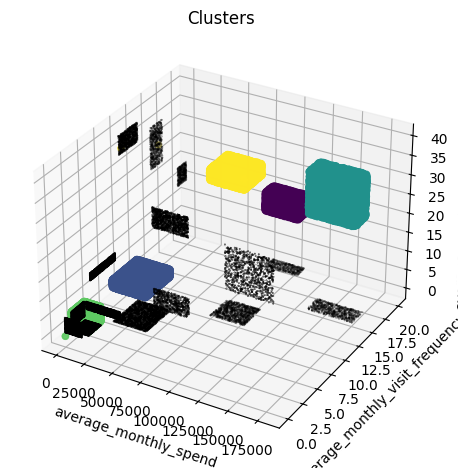

In [174]:
dataset['Cluster'] = clusters
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(dataset['average_monthly_spend'], dataset['average_monthly_visit_frequency'], dataset['average_monthly_basket_size'], c=clusters, cmap='viridis')
ax.set_xlabel('average_monthly_spend')
ax.set_ylabel('average_monthly_visit_frequency')
ax.set_zlabel('average_monthly_basket_size')
plt.title('Clusters')
ax.scatter(nan_rows['average_monthly_spend'], nan_rows['average_monthly_visit_frequency'], nan_rows['average_monthly_basket_size'],
           c='black',s = 0.1)
ax.set_xlabel('average_monthly_spend')
ax.set_ylabel('average_monthly_visit_frequency')
ax.set_zlabel('average_monthly_basket_size')


plt.show()

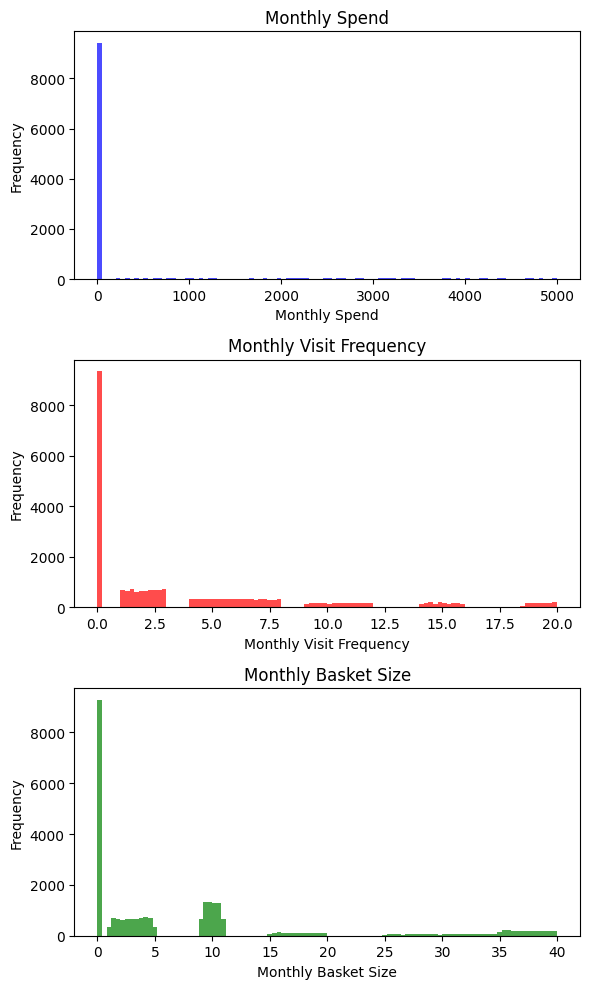

In [175]:
plt.figure(figsize=(6, 10))
plt.subplots_adjust(hspace=1)
plt.subplot(3, 1, 1)
plt.hist(nan_rows[nan_rows['average_monthly_spend'] < 5000]['average_monthly_spend'], bins=100, color='blue', alpha=0.7)
plt.title('Monthly Spend')
plt.xlabel('Monthly Spend')
plt.ylabel('Frequency')


plt.subplot(3, 1, 2)
plt.hist(nan_rows['average_monthly_visit_frequency'], bins=100, color='red', alpha=0.7)
plt.title('Monthly Visit Frequency')
plt.xlabel('Monthly Visit Frequency')
plt.ylabel('Frequency')

plt.subplot(3, 1, 3)
plt.hist(nan_rows['average_monthly_basket_size'], bins=100, color='green', alpha=0.7)
plt.title('Monthly Basket Size')
plt.xlabel('Monthly Basket Size')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

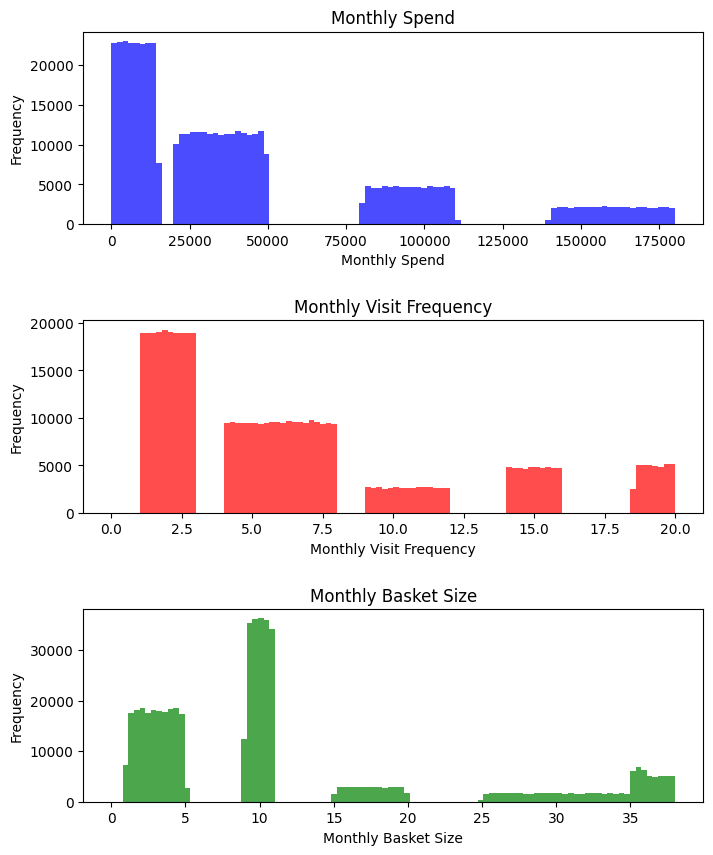

In [176]:
#draw histograms for each feature
plt.figure(figsize=(8, 10))
plt.subplots_adjust(hspace=0.5)

plt.subplot(3, 1, 1)
plt.hist(dataset['average_monthly_spend'], bins=100, color='blue', alpha=0.7)
plt.title('Monthly Spend')
plt.xlabel('Monthly Spend')
plt.ylabel('Frequency')

plt.subplot(3, 1, 2)
plt.hist(dataset['average_monthly_visit_frequency'], bins=100, color='red', alpha=0.7)
plt.title('Monthly Visit Frequency')
plt.xlabel('Monthly Visit Frequency')
plt.ylabel('Frequency')

plt.subplot(3, 1, 3)
plt.hist(dataset['average_monthly_basket_size'], bins=100, color='green', alpha=0.7)
plt.title('Monthly Basket Size')
plt.xlabel('Monthly Basket Size')
plt.ylabel('Frequency')

plt.show()

   Monthly Spend Cluster       min       max           mean
0                      0   80000.0  109999.0   94980.644267
1                      1   22087.0   49999.0   36050.439191
2                      2       0.0   22086.0    8378.438121
3                      3  140000.0  179998.0  159895.925440


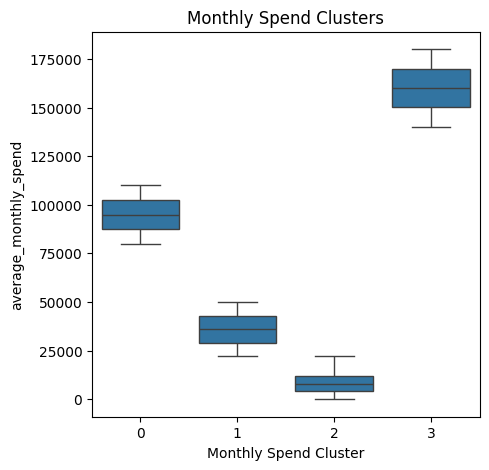

In [181]:
#cluster monthly spend into 4 categories using kmeans
month_dataset = copy_dataset[['average_monthly_spend']].dropna()
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(month_dataset)
month_dataset['Monthly Spend Cluster'] = clusters

#print cluster centers and ranges
cluster_centers = month_dataset.groupby('Monthly Spend Cluster')['average_monthly_spend'].agg(['min', 'max', 'mean']).reset_index()
print(cluster_centers)

#plot
plt.figure(figsize=(5, 5))
sns.boxplot(x='Monthly Spend Cluster', y='average_monthly_spend', data=month_dataset)
plt.title('Monthly Spend Clusters')
plt.show()

   Monthly Visit Frequency Cluster   min    max       mean
0                                0  18.5  19.99  19.247284
1                                1   4.0   7.99   5.996226
2                                2   0.0   3.40   1.994624
3                                3  14.0  15.99  14.994004
4                                4   9.0  11.99  10.497123


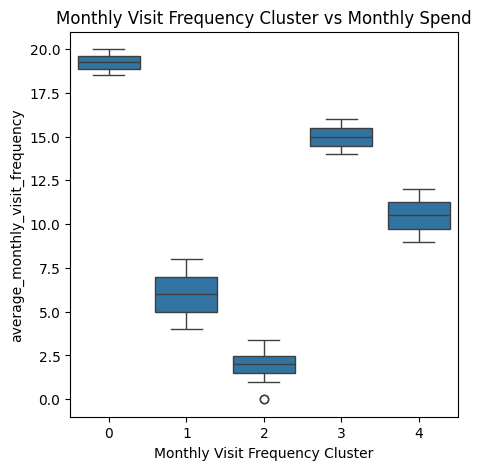

In [182]:
#cluster monthly visit frequency into 5 categories using kmeans
freq_dataset = copy_dataset[['average_monthly_visit_frequency']].dropna()
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(freq_dataset[['average_monthly_visit_frequency']])
freq_dataset['Monthly Visit Frequency Cluster'] = clusters

#print cluster centers and ranges
cluster_centers = freq_dataset.groupby('Monthly Visit Frequency Cluster')['average_monthly_visit_frequency'].agg(['min', 'max', 'mean']).reset_index()
print(cluster_centers)

#plot
plt.figure(figsize=(5, 5))
sns.boxplot(x='Monthly Visit Frequency Cluster', y='average_monthly_visit_frequency', data=freq_dataset)
plt.title('Monthly Visit Frequency Cluster vs Monthly Spend')
plt.show()


   Monthly Basket Size Cluster    min    max       mean
0                            0  15.00  26.03  18.340486
1                            1   0.00   4.99   2.992393
2                            2  26.04  38.00  33.651603
3                            3   9.00  10.99   9.993773


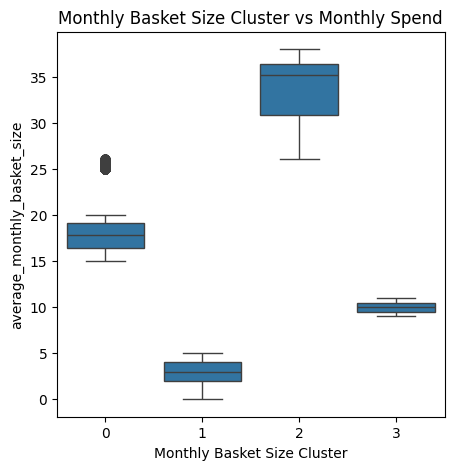

In [184]:
basket_dataset = copy_dataset[['average_monthly_basket_size']].dropna()
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(basket_dataset[['average_monthly_basket_size']])
basket_dataset['Monthly Basket Size Cluster'] = clusters

#print cluster centers and ranges
cluster_centers = basket_dataset.groupby('Monthly Basket Size Cluster')['average_monthly_basket_size'].agg(['min', 'max', 'mean']).reset_index()
print(cluster_centers)

#plot
plt.figure(figsize=(5, 5))
sns.boxplot(x='Monthly Basket Size Cluster', y='average_monthly_basket_size', data=basket_dataset)
plt.title('Monthly Basket Size Cluster vs Monthly Spend')
plt.show()

In [202]:
counts, edges = np.histogram(dataset['average_monthly_spend'], bins=200)

edge_detection = dict()
start = edges[0]
count = 0
for i in range(len(edges)-1):
    if (counts[i] == 0 and count != 0) or i == len(edges)-2:
        edge_detection[f"{i} : {count}"] = [start , edges[i]]
        start = edges[i]
        count = 0
    else:
        count += counts[i]

print(edge_detection)

{'17 189983': [0.0, 15299.83], '56 190117': [15299.83, 50399.44], '123 77977': [50399.44, 110698.77], '199 46445': [110698.77, 179098.01]}


In [205]:
counts, edges = np.histogram(dataset['average_monthly_visit_frequency'], bins=50)

edge_detection = dict()
start = edges[0]
count = 0
for i in range(len(edges)-1):
    if (counts[i] == 0 and count != 0) or i == len(edges)-2:
        edge_detection[f"{i} : {count}"] = [start , edges[i]]
        start = edges[i]
        count = 0
    else:
        count += counts[i]
    
print(edge_detection)

{'1 : 2': [0.0, 0.3998], '9 : 189979': [0.3998, 3.5982], '20 : 190117': [3.5982, 7.9959999999999996], '30 : 40003': [7.9959999999999996, 11.994], '40 : 47493': [11.994, 15.991999999999999], '49 : 27592': [15.991999999999999, 19.5902]}


ValueError: Could not interpret value `q` for `x`. An entry with this name does not appear in `data`.

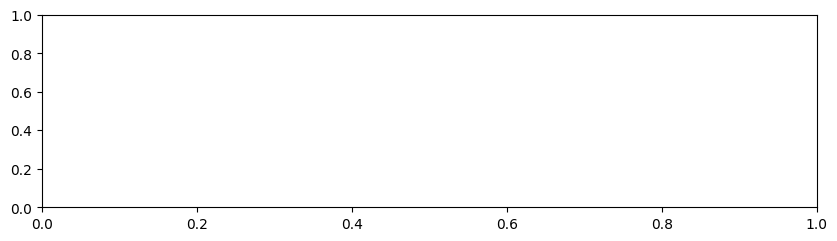

In [207]:
#plot box and whisker for each feature
plt.figure(figsize=(10, 10))
plt.subplots_adjust(hspace=0.5)

plt.subplot(3, 1, 1)
sns.boxplot(x='clusters', y='average_monthly_spend', data=dataset)
plt.title('Monthly Spend')
plt.xlabel('Cluster')
plt.ylabel('Monthly Spend')

plt.subplot(3, 1, 2)
sns.boxplot(x='Cluster', y='average_monthly_visit_frequency', data=dataset)
plt.title('Monthly Visit Frequency')
plt.xlabel('Cluster')

plt.show()